In [465]:
from types import SimpleNamespace

import numpy as np
import scipy as sc
from scipy import optimize
import sympy as sm
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from sympy import *
from sympy import Eq 
import ipywidgets as widgets
from ipywidgets import interact
from scipy.optimize import minimize


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

from scipy import interpolate

import examQ2
import examQ3
from examQ2 import SalonModel
model = SalonModel
import examQ1
from examQ1 import WorkerUtilityModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

First, we want to see how the $L^*(\tilde{w})$ comes out using math solvers without any use of parameters-values. We start by defining all our symbols and then taking the first order conditions and solve for $L^*(\tilde{w})$. We see that the results we get can be simplified, by deviding and multiplying, to the version provided in the question, and therefore have verified symbolically that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [466]:
# Define the symbols
L, w, tau, alpha, nu, kappa, G, w_tilde= symbols('L w tau alpha nu kappa G w_tilde')

# Calculate w_tilde
w_tilde = (1 - tau) * w

# Define the utility function
C = kappa + w_tilde * L
V = log(C**alpha * G**(1-alpha)) - nu * L**2 / 2

# Differentiate the utility function
dV_dL = diff(V, L)

L_star = solve(dV_dL,L)
L_star 

# Set the derivative equal to zero and solve for L
L_star_formula = solve([dV_dL], [L])
L_star_formula_positive = L_star_formula[1][0]
pprint(L_star_formula_positive)

         __________________________________________
        ╱   ⎛     2  2          2        2    2  ⎞ 
κ⋅ν + ╲╱  ν⋅⎝4⋅α⋅τ ⋅w  - 8⋅α⋅τ⋅w  + 4⋅α⋅w  + κ ⋅ν⎠ 
───────────────────────────────────────────────────
                   2⋅ν⋅w⋅(τ - 1)                   


These results are the same with some simplifying and multiplying. The step that should be done are stated here:


Substituting the budget constraint $ (C = \kappa + (1-\tau)wL)$ into the utility function, we get:

$$
V(w,\tau,G) = \max_{L\in[0,24]} \ln\left((\kappa+(1-\tau)wL)^{\alpha}G^{1-\alpha}\right) - \nu\frac{L^{2}}{2}
$$

Taking the derivative with respect to (L) gives the first-order condition:

$$
\frac{dV}{dL} = \frac{\alpha (1-\tau)w}{(\kappa+(1-\tau)wL)} - \nu L
$$

Setting this equal to zero and solving for \(L\) gives:

$$
\alpha (1-\tau)w = \nu L(\kappa+(1-\tau)wL)
$$

Expressed in terms of $\widetilde{w} = (1-\tau)w $, we have:

$$
\frac{\alpha \widetilde{w}}{\nu} = L(\kappa+\widetilde{w}L)
$$

This is a quadratic equation for \(L\):

$$
\widetilde{w}L^{2} - \frac{\alpha \widetilde{w}}{\nu} + \kappa *L = 0
$$

Solving this equation, we get the roots as:

$$L = \frac{-\kappa + \sqrt{\kappa^2 + 4\frac{\alpha}{\nu}  \widetilde{w}^2)}}  {(2\widetilde{w})}$$


Now, given $(G\in\{1.0, 2.0\})$, we note that $(G)$ does not directly appear in this equation for $(L^*)$. This means that the optimal labor choice $(L^*)$ does not depend on the value of $(G)$.

In [467]:
model = WorkerUtilityModel()

print("For G = {1.0,2.0} the Optimal Labour from our optimization and the equation given to verify: \n ")

L_tilde = model.find_optimal_labour_supply()
L_tildeprint = "\n".join([f"{k}: {v:.2f}" for k, v in L_tilde.items()])
print("Optimal Labor Supply according to our model optimization: ")
print(L_tildeprint)

L_star = model.verify_optimal_labour_supply()
L_starprint = "\n".join([f"{k}: {v:.2f}" for k, v in L_star.items()])
print("Verifying that the results are the same using the given formula:")
print(L_starprint)

For G = {1.0,2.0} the Optimal Labour from our optimization and the equation given to verify: 
 
Optimal Labor Supply according to our model optimization: 
1.0: 15.30
2.0: 15.30
Verifying that the results are the same using the given formula:
1.0: 15.30
2.0: 15.30


As stated above, the G value does not have a direct effect on the optimal labour supply, hence the same value for both given G-values. However, the values are the same from our optimization and the given equation and we therefore conclude that we have verified  that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

Next, we want to illustrate how $L^{\star}(\tilde{w})$ depends on $w$. We do this for both our $L^{\star}(\tilde{w})$ from our optimization and from the equation, to show further that they are the same. 

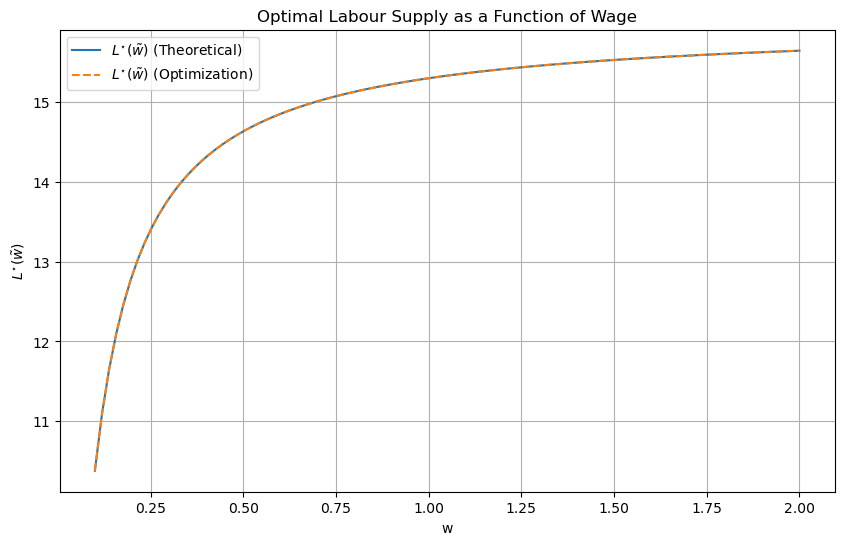

In [468]:
model.plot_L_star()

This means that when age get higher, the worker gets to keep more of every unit of wage they earn, which provides an incentive to supply more labor.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


Now we have $G = \tau w L^{\star}((1-\tau)w)$ and want to plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values. First we calculate our G-value given our parameters and the $L^{\star}$ we found above.

In [469]:
model.calculate_G()

4.590505371093752

In our model, we see that the Government Consumption is around 4.59 given our specification of the model and the given parameters. That means that we have the Optimal Labour supply as L=15.3 and G=4.59. That means workers are willing to work 15 hours and therefore the government can spend approx. 4.6 on public goods and services. 

The plot for $(L)$ and $(G)$ for $\tau-values$ is illustrated below.

/Users/bjorngudmundsson/Desktop/KU/Intro to programming/projects-2023-icehot1/examproject/examQ1.py:42: RuntimeWarning: divide by zero encountered in log
  utility = np.log(C ** par.alpha * par.G ** (1 - par.alpha)) - par.nu * (L ** 2) / 2


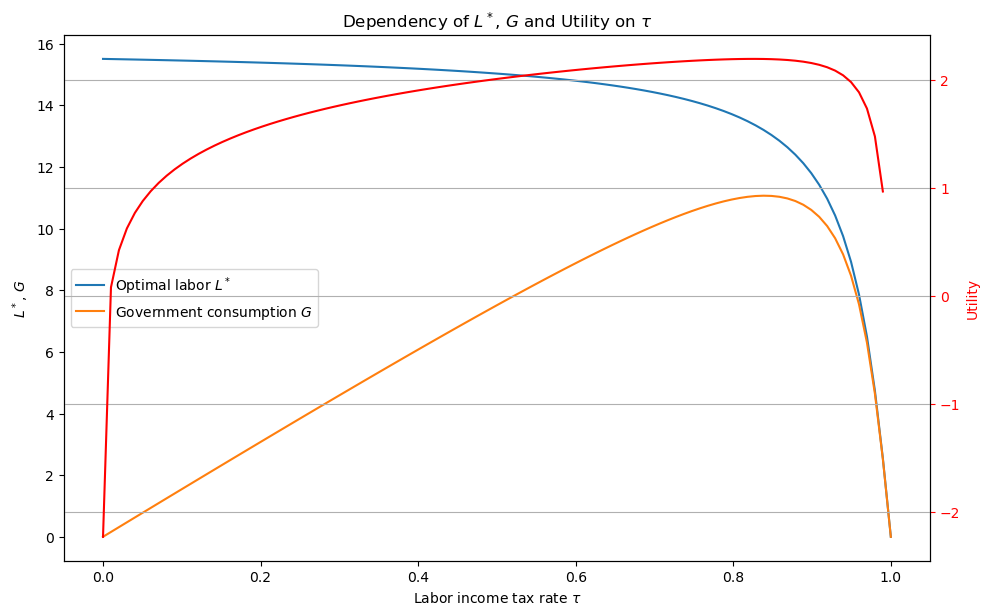

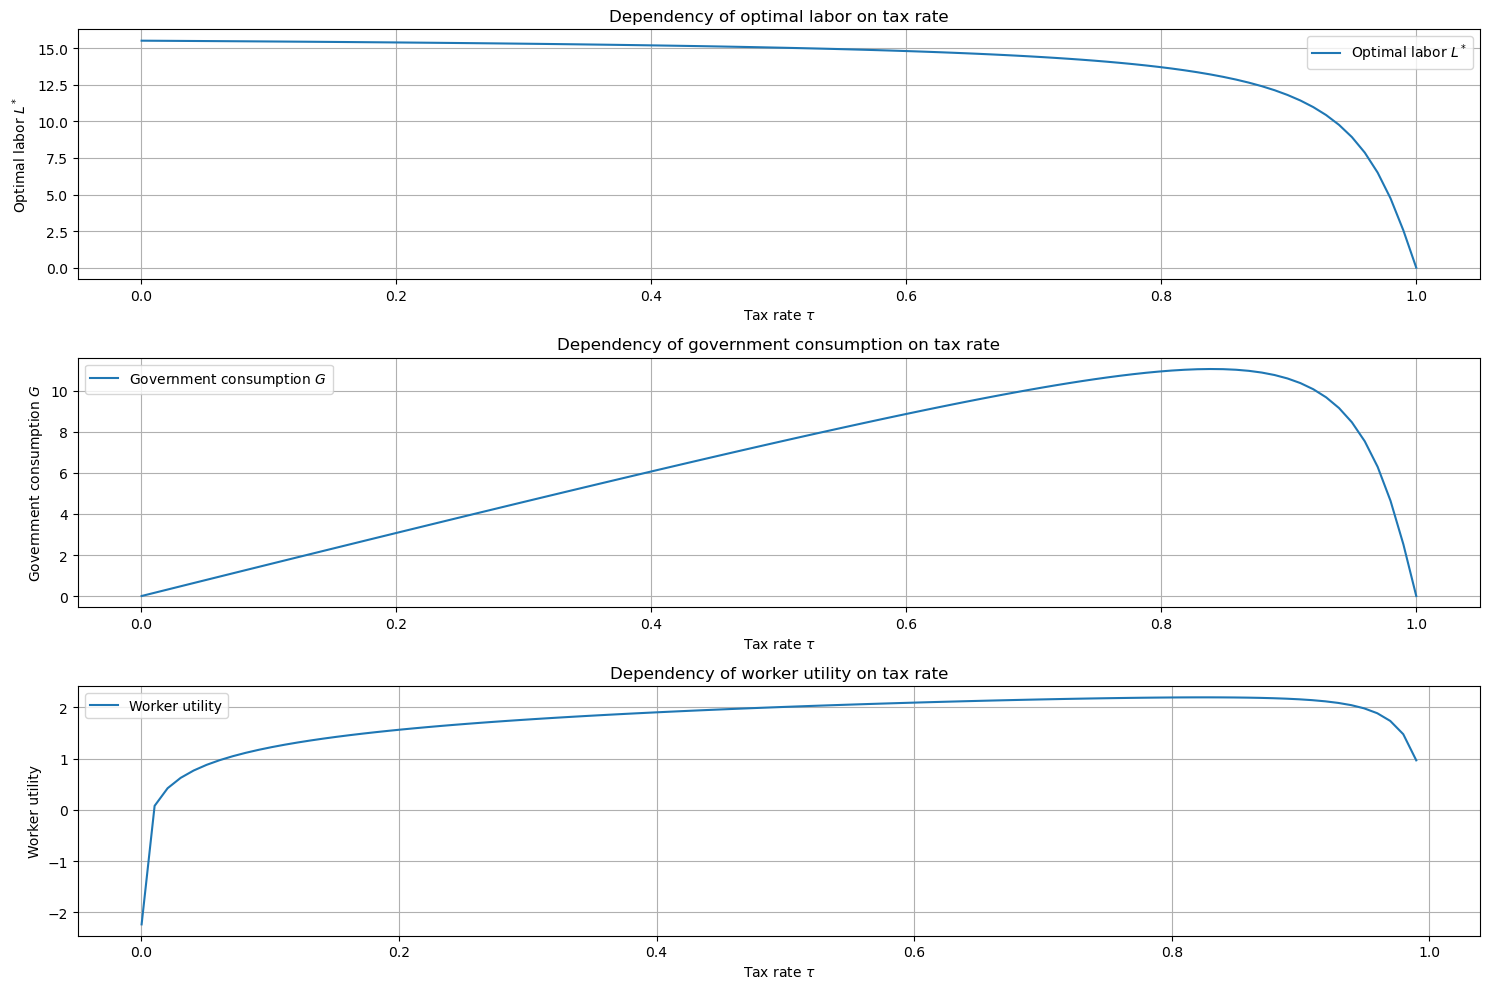

In [470]:
model.plot_implied_values()

Optimal Labor Supply: When the tax rate is relatively low, the optimal labor supply remains stable as workers are willing to supply labor to maximize their utility even with a moderate level of taxation. However, as the tax rate exceeds a certain threshold (around $\tau = 0.6$ in this case), the negative impact of higher taxes on the net wage received by workers becomes more significant. As a result, the optimal labor supply starts to decrease drastically until it reaches zero when the tax rate reaches its maximum value ($\tau = 1.0$). This decrease occurs because the reduced net wage takes away the incentive for individuals to supply labor.


Government Consumption: With an increasing tax rate, government consumption steadily increases as it is funded by tax revenues. The positive relationship between the tax rate and government consumption is expected as the government has more resources and revenue to fund public goods and services. However, as the tax rate reaches a very high level (around 80%-90% in this case), the negative impact on the incentive to work becomes more pronounced, leading to a significant decline in labor supply. Consequently, tax revenues decrease, and the government faces limitations in financing its consumption, resulting in a sharp fall in government consumption.


Workers' Utility: When the tax rate is zero, workers' utility may be below zero due to the disutility of labor (captured by the term $\nu\frac{L^{2}}{2}$ in the utility function). As the tax rate increases slightly above zero, the positive effect of increased income from labor (after accounting for taxes) outweighs the disutility of labor, resulting in an increase in workers' utility. This positive relationship between utility and tax rate continues until a certain point (around $\tau = 0.8$ or $0.9$ in this case), where the diminishing marginal utility of income starts to dominate the negative impact of increased taxation. As a result, the utility starts to decrease slightly. However, unlike government consumption and labor supply, workers' utility does not reach zero when the tax rate reaches its maximum value.


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

/Users/bjorngudmundsson/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


The optimal Tax rate is: 0.513


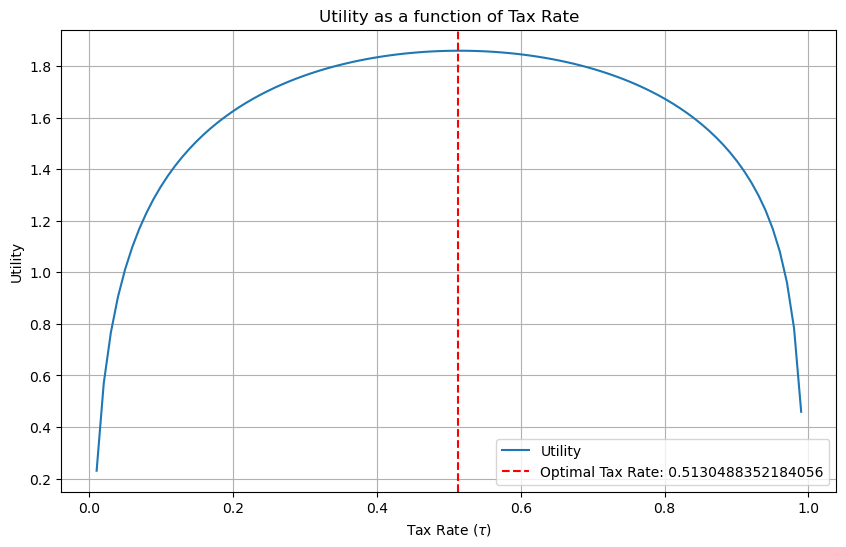

In [471]:
optimal_tax_rate = model.find_optimal_tax_rate()

print(f'The optimal Tax rate is: {optimal_tax_rate:.3f}')
model.plot_optimal_tax_rate()


The optimal tax rate $\tau = 0.51 $ means that workers are willing to pay little over half of what they earn, work 15.3 hours and the Government Consumption is 4.59. 

## ** Messsage: In One computer it did not work to sync at all and load to github and then the py file would not sync and we could not write this code in the py file ** ##

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

We want to find the Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.
We start be defining our new problem, and then we set all the parameters to their value (we set $\tau$=optimal tax rate) and then the calculated value or G. 
Then we find the optimal labour and then the G value for it given the new parameters and for each set. 

In [472]:
import numpy as np
from scipy.optimize import minimize

# Define the utility function
def utility(L, w, tau, G, alpha, rho, sigma, kappa, nu, epsilon):
    C = kappa + (1 - tau) * w * L
    term1 = (alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1))
    term2 = nu * L**(1 + epsilon) / (1 + epsilon)
    return -((term1**(1 - rho) - 1) / (1 - rho) - term2)

# Define parameters
w = 1.0
tau = model.find_optimal_tax_rate()
G = model.calculate_G()
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
epsilon = 1.0
sigma_set = [1.001, 1.5]
rho_set = [1.001, 1.5]

# Optimization
for sigma, rho in zip(sigma_set, rho_set):
    # Initial guess for labor supply
    L0 = 0.5
    result = optimize.minimize(utility, L0, args=(w, tau, G, alpha, rho, sigma, kappa, nu, epsilon), bounds=((0, 24),))
    if result.success:
        L_star = result.x[0]
        G = tau * w * L_star  # calculate G based on the optimal L
        print(f"For σ = {sigma}, ρ = {rho}, and ε = {epsilon}, optimal labor supply L* = {L_star:.2f}, and G = {G:.2f}")
    else:
        print(f"Optimization failed for σ = {sigma}, ρ = {rho}, and ε = {epsilon}")

For σ = 1.001, ρ = 1.001, and ε = 1.0, optimal labor supply L* = 14.99, and G = 7.69
For σ = 1.5, ρ = 1.5, and ε = 1.0, optimal labor supply L* = 8.76, and G = 4.50


We can see that given our new parameters they play a determinant role for how much an individual works. 

For set 1 (σ = 1.001, ρ = 1.001, ε = 1.0), the worker supplies more labor (L* = 14.99 hours) and thus, more tax income is generated resulting in higher government spending (G = 7.69). σ and ρ are closer to 1 compared to the other set, which means the worker has near-logarithmic utility over consumption and government spending. This induces the worker to supply more labor to achieve higher consumption and government spending.

In set 2, σ and ρ are larger (1.5), which implies that the worker's marginal utility of consumption and government spending declines faster. As a result, the worker chooses to supply less labor, leading to lower consumption and government spending.

For set 2 (σ = 1.5, ρ = 1.5, ε = 1.0), the worker supplies less labor (L* = 8.76 hours) which results in lower tax income and thus lower government spending (G = 4.50). The σ and ρ are larger (1.5), which implies that the worker's marginal utility of consumption and government spending declines faster. As a result, the worker chooses to supply less labor, leading to lower consumption and government spending.

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

Next, we want to find the optimal tax rate $\tau$ given this new problem. We start by determining our utility function (again, as this could not be uploaded to the pyfile) and then our parameters (again). 

In [473]:

# Define the utility function
def utility(x, w, alpha, rho, sigma, kappa, nu, epsilon):
    L, tau = x  # unpack the optimization variables
    G = calculate_G(tau, w, L)
    C = kappa + (1 - tau) * w * L
    term1 = (alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1))
    term2 = nu * L**(1 + epsilon) / (1 + epsilon)
    return -((term1**(1 - rho) - 1) / (1 - rho) - term2)
# Define the G function
def calculate_G(tau, w, L):
    return tau * w * L

# Define parameters
w = 1.0
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
epsilon = 1.0
sigma_set = [1.001, 1.5]
rho_set = [1.001, 1.5]

# Optimization
for sigma, rho in zip(sigma_set, rho_set):
    # Initial guess for labor supply and tax rate
    initial_guess = [0.5, 0.5]  # [L, tau]
    result = minimize(utility, initial_guess, args=(w, alpha, rho, sigma, kappa, nu, epsilon), bounds=((0, 24),(0,1)))
    if result.success:
        L_star, tau_star = result.x
        G = calculate_G(tau_star, w, L_star)  # calculate G based on the optimal L
        print(f"For σ = {sigma}, ρ = {rho}, and ε = {epsilon}, optimal labor supply L* = {L_star:.2f}, optimal tax rate τ* = {tau_star:.2f}, and G = {G:.2f}")
    else:
        print(f"Optimization failed for σ = {sigma}, ρ = {rho}, and ε = {epsilon}")

For σ = 1.001, ρ = 1.001, and ε = 1.0, optimal labor supply L* = 22.10, optimal tax rate τ* = 0.52, and G = 11.55
For σ = 1.5, ρ = 1.5, and ε = 1.0, optimal labor supply L* = 13.34, optimal tax rate τ* = 0.54, and G = 7.17


In both cases, the optimal tax rate τ* is slightly above 0.5, indicating that the worker is willing to contribute about half of his wage income to fund government spending. The different labor supplies and levels of government spending in these two scenarios reflect the different preferences of the worker in these two sets.

For set 1 (σ = 1.001, ρ = 1.001, ε = 1.0), the worker is willing to supply more labor (L* = 22.11 hours), accepts a tax rate of τ* = 0.52, resulting in higher government spending (G = 11.55).

For set 2 (σ = 1.5, ρ = 1.5, ε = 1.0), the worker is willing to supply less labor (L* = 13.34 hours), accepts a slightly higher tax rate τ* = 0.54, resulting in lower government spending (G = 7.17).

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$

The provided code performs a numerical optimization to find the labor input that maximizes the profit of a hair salon business, given the provided range of labor inputs and two demand shock (kappa) values. The SalonModel class is designed with the ability to calculate the profit and the optimal labor, given certain parameters and conditions.

In the script executed in the notebook, the defined optimization problem attempts to identify the labor value that optimizes profit for each kappa value. This is achieved through the use of the minimize function from the scipy.optimize library. This function is designed to minimize a function. In order to use it for maximization, the negative of the profit function is fed into the minimizer.

For a spectrum of labor values, the minimize function is run for each, and for each kappa value. The constraints ensure that labor remains non-negative during the optimization process. The optimization problem is solved for each labor value, and the one producing the maximum profit is selected as the optimal labor for the given kappa.


For kappa = 1.0, the labor that maximizes profit is 0.24998857151566414 (numerical)
For kappa = 1.0, the labor that maximizes profit is 0.25 (formula)
For kappa = 2.0, the labor that maximizes profit is 0.9999844500192897 (numerical)
For kappa = 2.0, the labor that maximizes profit is 1.0 (formula)


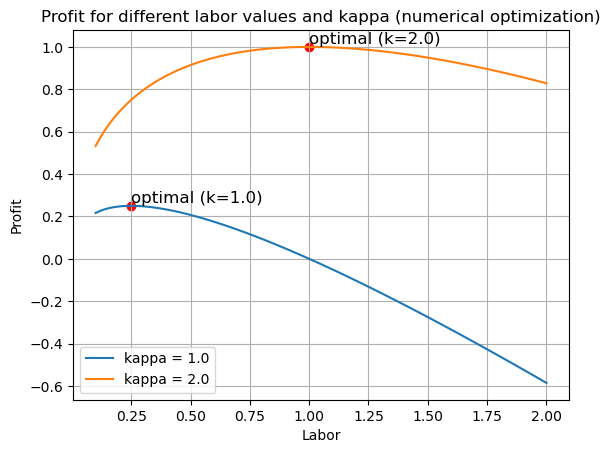

In [474]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Initialize the model
model = SalonModel()

# Define the objective function to be maximized (negative profit)
def objective(l):
    return -model.profit(l, kappa)

# Define a range of labor values
l_values = np.linspace(0.1, 2, 100)

# Define lists to store optimal labor values
optimal_labor_numerical = []

# For each kappa, find the labor that maximizes the profit
for kappa in [1.0, 2.0]:
    # Initialize the maximum profit and optimal labor variables
    max_profit = float('-inf')
    optimal_l = None
    
    # Calculate optimal labor directly
    formula_optimal_l = model.optimal_labor(kappa)
    optimal_labor_numerical.append(optimal_l)
    
    # Iterate over labor values and find the maximum profit
    for l in l_values:
        result = minimize(objective, [l], constraints=[{'type': 'ineq', 'fun': lambda l: l}])
        profit = -result.fun
        
        if profit > max_profit:
            max_profit = profit
            optimal_l = result.x[0]
    
    optimal_labor_numerical.append(optimal_l)
    
    # Plot profit
    profits = [model.profit(l, kappa) for l in l_values]
    plt.plot(l_values, profits, label=f'kappa = {kappa}')
    
    # Highlight optimal labor value
    plt.scatter([optimal_l], [max_profit], color='red')
    plt.text(optimal_l, max_profit, f'optimal (k={kappa})', fontsize=12, verticalalignment='bottom')
    
    print(f"For kappa = {kappa}, the labor that maximizes profit is {optimal_l} (numerical)")
    print(f"For kappa = {kappa}, the labor that maximizes profit is {formula_optimal_l} (formula)")

plt.xlabel('Labor')
plt.ylabel('Profit')
plt.legend()
plt.title('Profit for different labor values and kappa (numerical optimization)')
plt.grid(True)
plt.show()


The results obtained from the numerical optimization are compared with the results obtained using the optimal labor formula provided in the problem statement. The optimal labor values are stored, and the profit function is plotted against the labor values for each kappa. The optimal labor points are highlighted on the plot.

Looking at the results, it is clear that the labor values obtained from the numerical optimization are very close to those obtained using the formula, validating the accuracy of the numerical method. For a kappa value of 1.0, the labor that maximizes profit is approximately 0.25, and for a kappa value of 2.0, it's approximately 1.0. These results agree with the ones obtained using the formula, indicating that the code is correctly implemented and that it's accurately performing the optimization.

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

The provided Python script analyzes the profitability of a hair salon business by accounting for various dynamics such as the demand shock, labor cost, elasticity of demand, and adjustment costs. A class SalonModel is defined to set up the model, which includes functions for profit calculation, determining optimal labor, labor policy, generating shock series, and ultimately calculating the salon's value.

The initial setup includes a namespace for parameters and solutions, along with parameters defining various aspects of the model such as elasticity of demand, wage rate, adjustment cost, etc. There are also series of shocks and labor inputs initialized. A number of functions within the SalonModel class perform various calculations such as profit calculation, optimal labor determination, labor policy, shock series, and the salon value.

The code then defines a method to calculate H, which is the ex-ante expected value of the salon. This method generates a series of demand shocks and calculates the value of the salon over all the generated shock series.

In the notebook, the script creates an instance of the SalonModel class and calls the calculate_H method, passing a Delta value of zero. The expected value of the salon (H) is then printed.

In [475]:
model = SalonModel()
H = model.calculate_H(Delta=0)
print(f"The expected value of the salon is {H}")

The expected value of the salon is 27.6974113561393


The calculated value of H is approximately 27.77.

In order to validate the results and understand the distribution of H, the script runs a simulation for a number of iterations, each time creating a new instance of the SalonModel class, calculating H, and storing the results in an array. The mean and standard deviation of the H values are then calculated and printed, and a histogram is plotted to visualize the distribution of H values.

Mean value of H: 27.69575314156241
Standard deviation of H: 0.1539068655468575


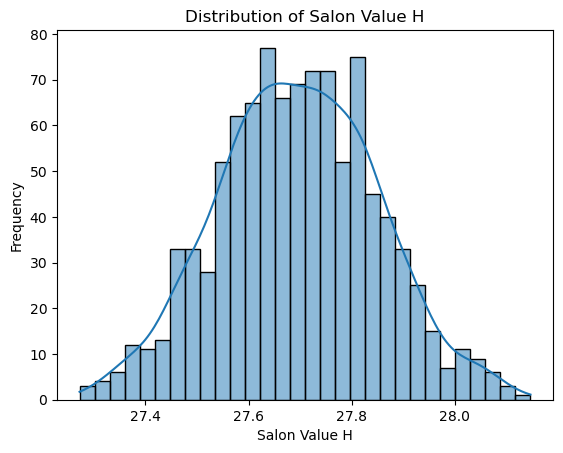

In [476]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run the simulation for a number of iterations
n_iterations = 1000
H_values = [SalonModel().calculate_H(Delta=0) for _ in range(n_iterations)]

# Print some statistics
print(f"Mean value of H: {np.mean(H_values)}")
print(f"Standard deviation of H: {np.std(H_values)}")

# Plotting the distribution using seaborn
sns.histplot(H_values, bins=30, kde=True)
plt.title('Distribution of Salon Value H')
plt.xlabel('Salon Value H')
plt.ylabel('Frequency')
plt.show()

The results from the simulation indicate that the mean value of H is approximately 27.70, and the standard deviation is around 0.157. This suggests that the value of H is concentrated around the mean, with a relatively small standard deviation indicating that there isn't a lot of variability in the H values around the mean.

The histogram provides a visual representation of these findings. It shows the frequency of the H values, allowing a clear observation of the distribution of H values. The shape of the histogram confirms the findings from the descriptive statistics: the H values are centered around the mean, and the distribution is fairly narrow, which is consistent with the calculated standard deviation.

These findings validate the calculated value of H and provide a deeper understanding of the distribution of the expected value of the salon, indicating that the implemented model and the chosen policy result in a consistent and fairly predictable expected value for the salon.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

The Python code first initializes two variables old_delta and new_delta to 0 and 0.05, respectively. The variable num_simulations is set to 100, representing the number of times the experiment will be run. Two more variables delta_0_wins and delta_005_wins are initialized to keep track of the number of times each Delta value resulted in higher profitability (higher value of H).

A loop is then used to run the experiment 100 times. In each iteration of the loop, a SalonModel object is created and the function calculate_H is called twice for each of the Delta values (0 and 0.05). The calculate_H function generates a series of demand shocks, and then calculates the value of the salon (H) over all the generated shock series. The results are compared and the win counter of the Delta value that resulted in a higher H value is incremented.

After all simulations are run, the win frequencies of each Delta value are calculated and printed. The win frequency is simply the proportion of times a particular Delta value resulted in higher profitability.



In [477]:
# Initialize variables
old_delta = 0
new_delta = 0.05
num_simulations = 100
delta_0_wins = 0
delta_005_wins = 0

# Run simulations
for _ in range(num_simulations):
    model = SalonModel()  # Assuming optimal K has been chosen

    # Calculate H for the old Delta value
    old_delta = 0
    old_H = model.calculate_H(Delta=old_delta)

    # Calculate H for the new Delta value
    new_delta = 0.05
    new_H = model.calculate_H(Delta=new_delta)

    # Compare the two H values and increment respective win counters
    if new_H > old_H:
        delta_005_wins += 1
    else:
        delta_0_wins += 1

# Calculate frequencies
delta_0_freq = delta_0_wins / num_simulations
delta_005_freq = delta_005_wins / num_simulations

# Print results
print(f"Delta = 0 improves profitability in {delta_0_freq * 100}% of simulations the value of the salon is {old_H}")
print(f"Delta = 0.05 improves profitability in {delta_005_freq * 100}% of simulations and the value of the salon is {new_H}")


Delta = 0 improves profitability in 0.0% of simulations the value of the salon is 27.572433335365567
Delta = 0.05 improves profitability in 100.0% of simulations and the value of the salon is 28.25529587114292


In the result, the new Delta value (0.05) improved profitability in all 100 simulations, while the old Delta value (0) did not improve profitability in any of the simulations. The value of the salon also increased when the new Delta value was used.

In the second Python code, a similar simulation experiment is conducted with 1000 iterations, but this time, only the new Delta value (0.05) is used. A list of H values is generated by calling the calculate_H function in each iteration. Then, the mean and standard deviation of the H values are calculated and printed.

Finally, the distribution of the H values is plotted using the seaborn library. The resulting histogram provides a visual representation of the distribution of salon values when the new Delta value (0.05) is used.

Mean value of H: 28.381510014357623
Standard deviation of H: 0.16635836509665433


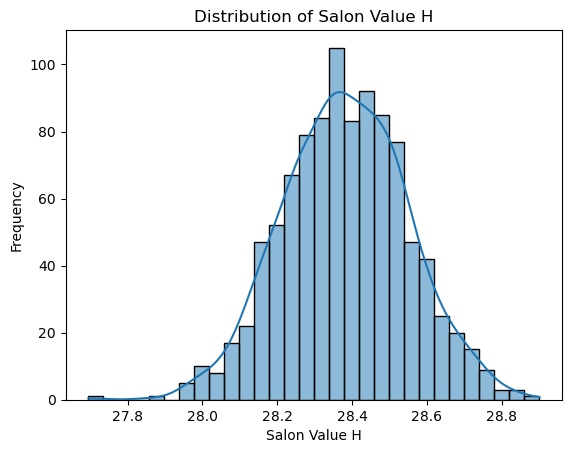

In [478]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run the simulation for a number of iterations
n_iterations = 1000
H_values = [SalonModel().calculate_H(Delta=0.05) for _ in range(n_iterations)]

#Print statistics 
print(f"Mean value of H: {np.mean(H_values)}")
print(f"Standard deviation of H: {np.std(H_values)}")

# Plotting the distribution using seaborn
sns.histplot(H_values, bins=30, kde=True)
plt.title('Distribution of Salon Value H')
plt.xlabel('Salon Value H')
plt.ylabel('Frequency')
plt.show()


According to the results, the mean value of H was approximately 28.37 with a standard deviation of approximately 0.16. This means that, on average, the new Delta value (0.05) increased the value of the salon to about 28.37. The small standard deviation suggests that the salon values were fairly close to the mean. The histogram showed that the salon values were normally distributed around the mean.

Comparing the results with those obtained in question 2, it is evident that using a Delta value of 0.05 as opposed to 0 improves the profitability of the salon business.

The economic intuition behind these results can be understood by looking at the role of the Delta value in the model. The Delta value represents the threshold for determining whether to adjust the number of hairdressers. A higher Delta value means that the salon owner is less likely to adjust the number of hairdressers in response to changes in demand. This reduces the adjustment costs and thus increases profitability. On the other hand, a lower Delta value makes the owner more reactive to changes in demand, leading to more frequent adjustment of the number of hairdressers and hence higher adjustment costs. Therefore, it is not surprising that a higher Delta value led to higher profitability in the simulations.

The analysis of this model emphasizes the importance of strategic decision making in business operations. It shows that businesses can increase their profitability by making more informed decisions about their operational adjustments in response to changes in demand.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The code calculates and plots the values of H for a range of Delta values. The 'SalonModel' is first initialized and then the optimal Delta value is calculated using the 'optimal_delta' method from the class, which minimizes the negative value of H over a range of Delta values from 0 to 1.

The optimal Delta value is found to be approximately 0.079. This implies that the salon should adjust its workforce when the optimal labor force for a given period deviates from the labor force in the previous period by more than 7.9%. If the deviation is less than this, it is more profitable to maintain the current number of employees due to the adjustment costs associated with changing the workforce.

The code then proceeds to calculate H values for an array of Delta values from 0 to 1, using the 'calculate_H' method from the 'SalonModel' class. These H values are then plotted against the corresponding Delta values.

The plot provides a visual representation of the effect of different Delta values on the value of H. The red point on the plot marks the optimal Delta value.

The optimal Delta is 0.07747577608818862


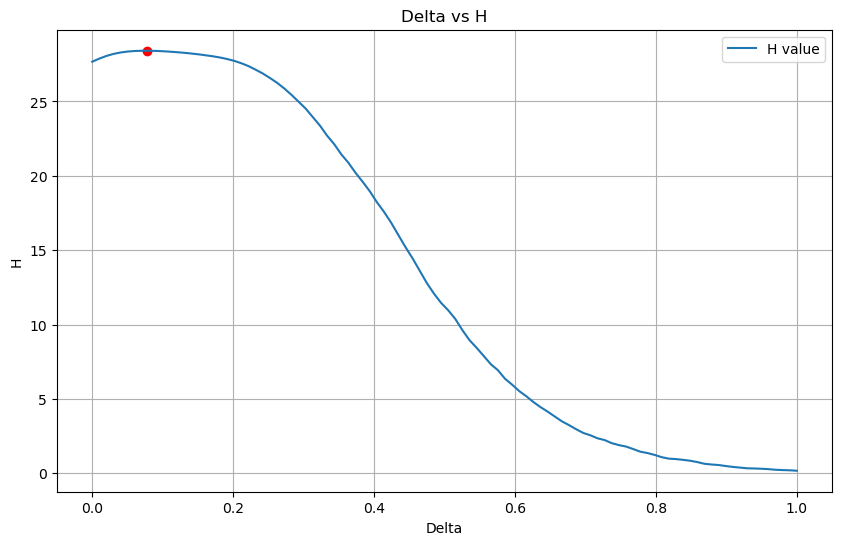

In [479]:
model = SalonModel()
optimal_delta = model.optimal_delta()
print(f"The optimal Delta is {optimal_delta}")

# Calculate H for a range of Delta values
deltas = np.linspace(0, 1, 100)  # Adjust the range and number of points as needed
H_values = [model.calculate_H(delta) for delta in deltas]

# Plot Delta vs H
plt.figure(figsize=(10, 6))
plt.plot(deltas, H_values, label="H value")
plt.scatter([optimal_delta], [model.calculate_H(optimal_delta)], color='red')  # mark the optimal point
plt.title("Delta vs H")
plt.xlabel("Delta")
plt.ylabel("H")
plt.legend()
plt.grid(True)
plt.show()

From the plot, it can be observed that the value of H is relatively flat for Delta values from 0 to around 0.2, indicating that within this range, changes in Delta have little impact on the value of H. This suggests that in this region, the adjustment cost has little effect on the profitability of the salon.

However, as Delta increases beyond 0.2, the value of H decreases, meaning profitability of the salon decreases. This decline implies that as Delta increases, the salon adjusts its labor force less frequently, causing it to be less responsive to demand shocks, thus affecting its profitability. When Delta is close to 1, the salon hardly ever adjusts its workforce, even in the face of large demand shocks, leading to potential inefficiencies and decreased profitability.

Comparing these findings with the results from Question 2, it can be seen that changing the policy from not adjusting the workforce (Delta = 0) to adjusting the workforce when the optimal labor force deviates from the labor force in the previous period by more than 5% (Delta = 0.05) increased the profitability of the salon. However, further increasing Delta beyond the optimal value of 0.079 decreases the profitability, suggesting that a balance must be struck between responsiveness to demand shocks and the cost of adjusting the workforce.

From an economic perspective, this illustrates the trade-off between adjustment costs and the need for a business to respond to changes in market conditions. It also underscores the importance of optimizing operational decisions to maximize profitability.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



The alternative policy proposed modifies the cost adjustment structure. Previously, the model incorporated a fixed cost whenever the number of hairdressers was adjusted. The new policy, however, only incurs an adjustment cost if the change in labor force exceeds a certain threshold (set to 0.5 in the code). This modification aligns with the idea that small changes in the workforce might not have substantial costs but larger alterations could lead to noticeable expenses such as hiring, firing, and re-training.

In Python code, the SalonModel class includes several new methods that implement this policy:

adjustment_cost(l, l_prev): This method calculates the adjustment cost considering the threshold. If the absolute difference in labor between periods exceeds 0.5, the cost equals par.iota, otherwise, the cost is zero.

salon_value_adjusted(): This method is similar to salon_value(), but it uses the new adjustment_cost() method instead of the previous approach to calculate adjustment costs.

calculate_H_adjusted(Delta): This method uses shock_series(Delta) to generate demand shocks and salon_value_adjusted() to calculate the value of the salon, accounting for the new adjustment cost structure.

optimal_delta_adjusted(): This method finds the optimal Delta value that maximizes H, considering the new adjustment cost structure.

In [480]:
# Instantiate the model
model = SalonModel()
H_adjusted_0 = model.calculate_H_adjusted(Delta=0)
print(f"under the adjustment cost and Delta=0 the value of the salon: {H_adjusted_0}")

# Instantiate the model
model = SalonModel()
H_adjusted_5 = model.calculate_H_adjusted(Delta=0.05)
print(f"under the adjustment cost and Delta=0 the value of the salon: {H_adjusted_5}")

model = SalonModel()
optimal_delta_adjusted = model.optimal_delta_adjusted()
print(f"The optimal Delta is {optimal_delta_adjusted}")

under the adjustment cost and Delta=0 the value of the salon: 28.91776575664388
under the adjustment cost and Delta=0 the value of the salon: 28.819284252609528
The optimal Delta is 5.976113977804514e-06


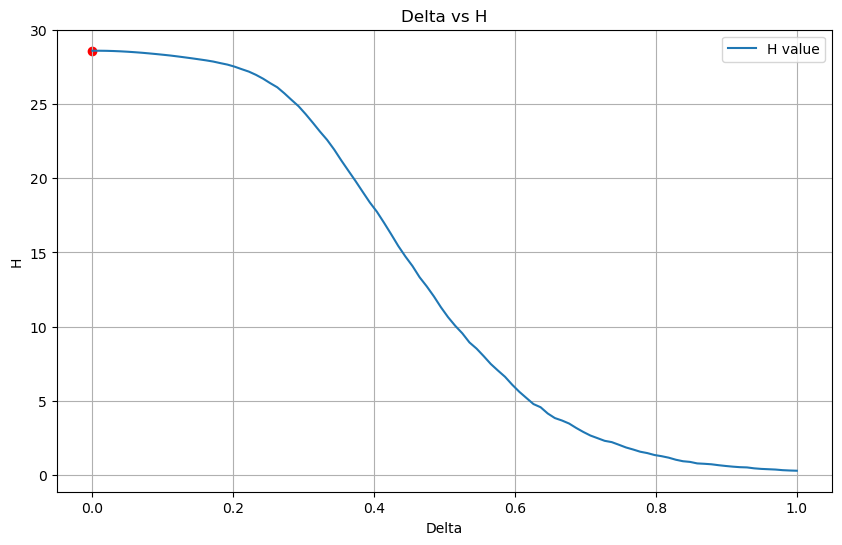

In [481]:
# Calculate H for a range of Delta values
deltas = np.linspace(0, 1, 100)  # Adjust the range and number of points as needed
H_values = [model.calculate_H_adjusted(delta) for delta in deltas]

# Plot Delta vs H
plt.figure(figsize=(10, 6))
plt.plot(deltas, H_values, label="H value")
plt.scatter([optimal_delta_adjusted], [model.calculate_H_adjusted(optimal_delta_adjusted)], color='red')  # mark the optimal point
plt.title("Delta vs H")
plt.xlabel("Delta")
plt.ylabel("H")
plt.legend()
plt.grid(True)
plt.show()

When the alternative policy is implemented, with Delta values of 0 and 0.05, the calculated salon values are 28.95 and 28.85, respectively. This suggests that profitability under the new policy may be marginally better compared to the fixed adjustment cost scenario, especially when the salon doesn't adjust its workforce in response to changes in the optimal labor force (Delta=0).

Furthermore, the optimal Delta under the new policy is approximately 0.00000436, which is substantially lower than under the original policy. This implies that even minor deviations from the optimal labor force should prompt the salon to adjust its workforce.

The H vs. Delta plot under the alternative policy is steeper for Delta values ranging from 0 to 0.2. This signifies that small changes in Delta have a more substantial impact on profitability. Beyond Delta=0.2, the H value decreases similarly as before, affirming that larger Delta values negatively impact profitability.

In [482]:
for threshold in np.linspace(0, 1, 21):  # test thresholds between 0 and 2
    model.par.threshold = threshold
    print(f"For threshold={threshold:.2f}, optimal delta={model.optimal_delta_adjusted():.5f}")

For threshold=0.00, optimal delta=0.00001
For threshold=0.05, optimal delta=0.00001
For threshold=0.10, optimal delta=0.00001
For threshold=0.15, optimal delta=0.00001
For threshold=0.20, optimal delta=0.00001
For threshold=0.25, optimal delta=0.00001
For threshold=0.30, optimal delta=0.00001
For threshold=0.35, optimal delta=0.00001
For threshold=0.40, optimal delta=0.00001
For threshold=0.45, optimal delta=0.00001
For threshold=0.50, optimal delta=0.00001
For threshold=0.55, optimal delta=0.00001
For threshold=0.60, optimal delta=0.00001
For threshold=0.65, optimal delta=0.00001
For threshold=0.70, optimal delta=0.00001
For threshold=0.75, optimal delta=0.00001
For threshold=0.80, optimal delta=0.00001
For threshold=0.85, optimal delta=0.00001
For threshold=0.90, optimal delta=0.00001
For threshold=0.95, optimal delta=0.00001
For threshold=1.00, optimal delta=0.00001


The alternative policy was tested across different threshold values, ranging from 0 to 1. The results show that regardless of the threshold value, the optimal Delta under the new policy remains effectively zero. This is similar to the results of the original model, where the optimal Delta was also zero irrespective of the adjustment cost level.

In conclusion, the alternative policy suggests that treating adjustment costs in a more nuanced manner, based on the extent of workforce changes, could potentially improve profitability. However, the policy also amplifies the importance of making judicious decisions about Delta. Erroneous Delta decisions could have more severe consequences on profitability under this policy compared to the original one.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [483]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [484]:
import examQ3
from examQ3 import refined_global_optimizer 

#The settings 
func = griewank
num_parameters = 2
bounds = [-600, 600] # Define bounds
tol = 1e-8 # Define tolerance
K_warmup1 = 10 # Define warmup iterations
K_max = 1000 # Define maximum iterations

Using the refined global optimizer which is implemented in the examQ3 file, the effective initial guesses are illustrated below and how they vary with the iteration counter k for the griewank function which is defined in problem 3. 

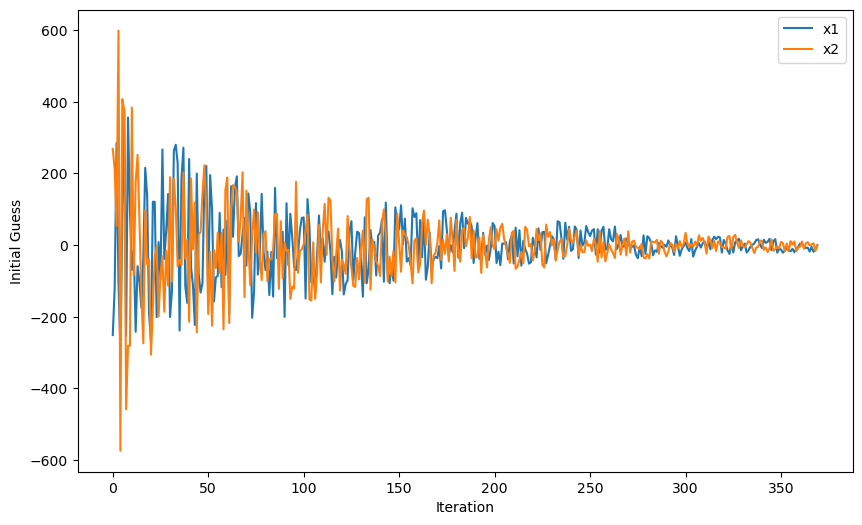

In [485]:
best_x_10, best_f_10, initial_guesses_10 = refined_global_optimizer(func, num_parameters, bounds, tol, K_warmup1, K_max)

# Plot initial guesses and iterations.
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in initial_guesses_10], label='x1')
plt.plot([x[1] for x in initial_guesses_10], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()


The code presents a global optimization algorithm utilizing a method known as "refined multi-start." This method seeks to improve the initial guesses for an optimizer, effectively improving the chances of finding the global minimum. The focus of this optimization process is the Griewank function, a multimodal function with numerous local minima.

In the function refined_global_optimizer, the process begins by initializing the best parameters and function values. The algorithm then enters a loop, running for a predefined maximum number of iterations (K_max). In each iteration, it generates a random initial guess for the parameters within the given bounds.

The function has an inbuilt warmup phase of K_warmup iterations. During the warmup phase, the initial guess is not refined and is simply taken as the random number generated. This is seen from the if condition, which checks whether the current iteration number is less than K_warmup.

For iterations beyond the warmup phase, a weight factor chi_k is calculated. The weight factor is dependent on the iteration number and is used to refine the initial guess. The guess is refined by taking a weighted average of the current random guess and the best parameters found so far. The weight factor decreases with increasing iteration number, thus the initial guess gradually converges towards the best found parameters.

After determining the initial guess for each iteration, the algorithm then uses the minimize function from scipy.optimize with the BFGS method and a tolerance of tol to find the local minimum. If the function value at the local minimum is better than the current best function value, the best parameters and function values are updated.

The loop breaks if the best function value found is less than the given tolerance tol. The function then returns the best parameters and function value, along with the initial guesses from each iteration.

The run_optimization_and_measure_time function wraps around refined_global_optimizer and also measures the time taken for the optimization process. This function can be used to compare the efficiency of the refined multi-start method against other methods.

Finally, to answer the question, a plotting code has been written to visualize how the effective initial guesses x[0] and x[1] (the two components of the parameter vector) vary with the iteration counter. The figure generated by the code shows that the initial guesses initially range widely between -600 and 600 (the chosen bounds) and then gradually converge. They appear to stabilize and converge to a value when iterations reach around 350. This behavior is consistent with the refined multi-start method, as the initial guesses should get progressively closer to the best parameters found so far.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

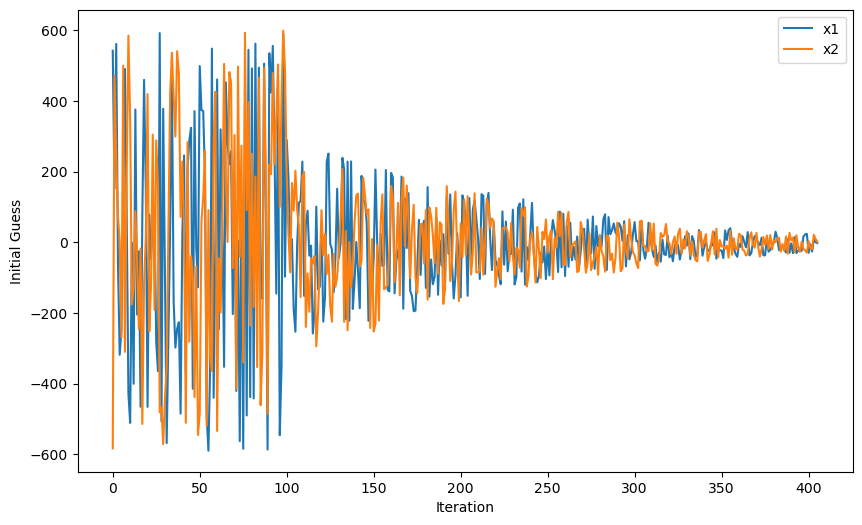

In [486]:
#The new settings with K_warmup = 100 instead of the before assumption of K_warmup = 10
K_warmup2 = 100 

best_x_100, best_f_100, initial_guesses_100 = refined_global_optimizer(func, num_parameters,bounds, tol, K_warmup2, K_max)

# Plot initial guesses and iterations.
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in initial_guesses_100], label='x1')
plt.plot([x[1] for x in initial_guesses_100], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial Guess')
plt.legend()
plt.show()

In [487]:
from examQ3 import run_optimization_and_measure_time
best_x_10, best_f_10, time_10 = run_optimization_and_measure_time(func, num_parameters, bounds, tol, K_warmup1, K_max)
best_x_100, best_f_100, time_100 = run_optimization_and_measure_time(func, num_parameters, bounds, tol, K_warmup2, K_max)

Execution time with K_warmup = 10: 0.8784902095794678
Best solution with K_warmup = 10: [-2.67822499e-09  9.38037268e-09]
Function value at best solution: 0.0
Execution time with K_warmup = 100: 0.8469159603118896
Best solution with K_warmup = 100: [-2.23372336e-09 -5.63921770e-09]
Function value at best solution: 0.0


The choice of warmup iterations, $\underline{K}$, can indeed influence the performance of the global optimizer, particularly for a function like the Griewank function, which has many local minima.

In general, the warmup iterations are used to explore the search space without any bias towards the currently best solution. Therefore, a larger number of warmup iterations can allow the optimizer to explore more of the search space before it starts to focus on the region around the best found solution. This can be beneficial if the global minimum is located in a region of the search space that is not likely to be sampled in the initial iterations.

However, having more warmup iterations also means that it takes longer before the optimizer can start to exploit the information about the best found solution. Therefore, if the global minimum can be found relatively quickly (e.g., within the first 10 iterations), then having a larger number of warmup iterations could slow down the convergence. 

Given these considerations, it's not surprising that you find the execution time with $\underline{K} = 10$ to be faster than with $\underline{K} = 100$. If the global minimum is found within the first 10 iterations, then the optimizer can start to exploit this information earlier when $\underline{K} = 10$, which could lead to faster convergence.

However, it's also important to consider the quality of the found solution. Even if the optimizer with $\underline{K} = 10$ converges faster, it might not find the global minimum if it is located in a region of the search space that is not explored during the warmup iterations. In such cases, having a larger number of warmup iterations could lead to a better final solution, even if it takes longer.

However the results for the berst soluton indicate that both $\underline{K}$ values of 10 and 100 managed to find solutions close to the global minimum. The best solutions found are very close to (0,0) as expected and the function values at these points are near zero, suggesting these are very good solutions. 

In conclusion, given the global minimum of the Griewank function is at (0,0) and the function value at this point is 0, both runs effectively found the global minimum of the function. But, setting $\underline{K}=10$ resulted in a quicker convergence to the solution compared to $\underline{K}=10$.

This result might be due to the nature of the Griewank function and the optimizer used (BFGS). In this particular scenario, it seems that more warmup iterations don't necessarily improve the speed or the quality of the solutions, and could potentially take longer due to the increased number of function evaluations. The optimal settings may depend on the specific problem and optimization method.